# Neutron emission from a tokamak plasma
Here we show an example of how to use the `dress` package to calculate the DD neutron emission from a tokamak plasma. In order to perform these kind of calculations, we need the following input data:

- The deuterium density and temperature profiles
- The plasma rotation (angular frequency profile)
- The distribution of fast (supra-thermal) deuterons, if present

For this example, we have obtained the above input data from a TRANSP simulation of JET discharge #96100 (except for the angular frequency profile, which is a mock-up, since this particular TRANSP simulation did not include any rotation data). The data can be found in the .npz archives `plasma.npz` and `fast_deuterons.npz`. We start by loading and plotting this data. All units have been converted to the units that DRESS expects (temperatures and energies in keV, momenta in keV/c, masses in keV/c^2 and all other quantities in SI units).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plasma = np.load('plasma.npz')
fast_deuterons = np.load('fast_deuterons.npz')

print(f'Plasma quanteties: {plasma.files}')
print(f'Fast D quanteties: {fast_deuterons.files}')

Plasma quanteties: ['nd', 'Ti', 'ang_freq', 'rho']
Fast D quanteties: ['F', 'E', 'pitch', 'density', 'R', 'Z', 'rho', 'dV']


Text(0, 0.5, 'angular frequency (rad/s)')

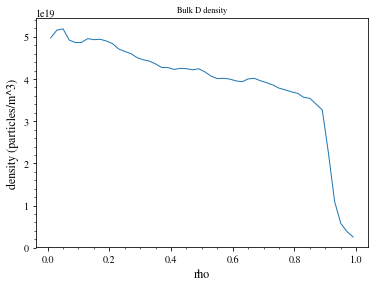

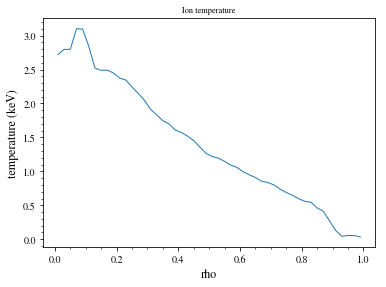

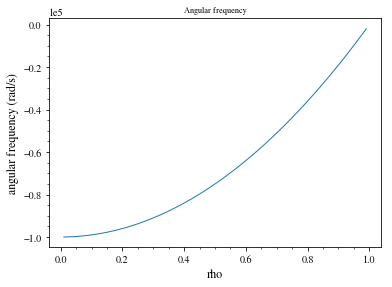

In [2]:
# Plasma profiles
plt.figure()
plt.plot(plasma['rho'], plasma['nd'])
plt.title('Bulk D density')
plt.xlabel('rho')
plt.ylabel('density (particles/m^3)')

plt.figure()
plt.plot(plasma['rho'], plasma['Ti'])
plt.title('Ion temperature')
plt.xlabel('rho')
plt.ylabel('temperature (keV)')

plt.figure()
plt.plot(plasma['rho'], plasma['ang_freq'])
plt.title('Angular frequency')
plt.xlabel('rho')
plt.ylabel('angular frequency (rad/s)')

(1.8931929121597262, 3.911047702019433, -1.336941094652356, 1.8179012680944262)

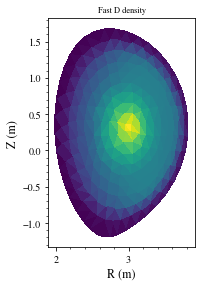

In [3]:
# Plot fast D density
plt.figure()
plt.tripcolor(fast_deuterons['R'], fast_deuterons['Z'], fast_deuterons['density'])
plt.title('Fast D density')
plt.xlabel('R (m)')
plt.ylabel('Z (m)')
plt.axis('scaled')

The fast D distribution is a 3D array `F`, which gives the (E,pitch) distribution at a number of (R,Z) locations. The (R,Z) points are given by the 1D arrays `R` and `Z` (note that these arrays do not define a rectangular grid!). The energy and pitch axes are given by the 1D arrays `E` and `pitch` (these arrays do define a rectanular grid). Hence, the value `F[i,j,k]` is the distribution value at the point (`R[i]`, `Z[i]`, `E[j]`, `pitch[k]`).

Text(0, 0.5, 'pitch')

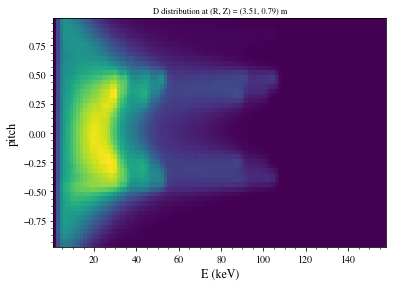

In [4]:
# Plot the (E, pitch) distribution at a given point
plt.figure()
i_spatial = 100       # change this value to see other locations...
R = fast_deuterons['R'][i_spatial]
Z = fast_deuterons['Z'][i_spatial]
F = fast_deuterons['F'][i_spatial].T      # need to transpose due to convention in plt.pcolor
plt.pcolor(fast_deuterons['E'], fast_deuterons['pitch'], F)
plt.title(f'D distribution at (R, Z) = ({round(R,2)}, {round(Z,2)}) m')
plt.xlabel('E (keV)')
plt.ylabel('pitch')

## Preparing input for DRESS
Now that we have all the relevant plasma profiles, we proceed to couple this to the `dress` framework. Spectrum calculations with `dress` are closely tied to two concepts:

* **Volume elements**, which specify regions of space where from where we want to calculate reaction product spectra. For a tokamak this would be a number of plasma volumes from which we want to evaluate e.g. the neutron spectrum. In `dress` each volume element is an object that holds information about the its position, volume, emission direction of interest, solid angle that the particle of interest is emitted into etc. `dress` will loop over all available volume elements and compute the spectrum from each. The user can select whether the spectra should be summed together (e.g. if computing the volume integrated neutron spectrum from a spectrometer viewing cone), or if each spetrum should be returned separately (e.g. if computing the neutron emissivity profile from the tokamak plasma).

* In order to compute a spectrum from a given volume element, we need to supply the relevant **reactant distributions** for each volume element. `dress`then has tools for sampling these distributions, evaluating the relevant reaction cross section and assempling the reaction product spectrum of interest.

The tools required for creating volume elements and reactant distributions are found in the sub-modules `dress.utils`.

In the present example, we will evaluate the (energy resolved) neutron emissivity profile from the above plasma, as well as the total volume integrated neutron energy spectrum. It is then natural to take each of the spatial zones for the fast D distribution as one volume element for `dress`. We can then create the volume elements as follows (see the docstring of `dress.utils.make_vols` for more details):

In [5]:
import dress.utils

dV = fast_deuterons['dV']
solid_angle = 4*np.pi*np.ones_like(dV)
pos = (fast_deuterons['R'], fast_deuterons['Z'])
vols = dress.utils.make_vols(dV, solid_angle, pos=pos)

Next, we create a distribution object from the fast D distribution. The fast D distribution loaded above is already in the correct format for `dress`, but in order to create the distribution object we also need to provide information about how to interpret the pitch coordinate. I.e. we need to provide the reference direction with respect to which the pitch values are given. For the distribution loaded above, the pitch values are given relative to the plasma magnetic field, so we need to provide the magnetic field at each of the spatial locations. For simplicity, we here assume the magnetic field to be purely toroidal. Furthermore, for the TRANSP simulation under consideration, the B-field was directed clockwise when viewing the tokamak from above. It is then convenient to work in cylindrical coordinates, in which B = [0,-1,0] 

The distribution object can now be calculated as follows (see the docstring of `dress.utils.make_dist` for more details):

In [6]:
Npoints = len(fast_deuterons['rho'])
density = fast_deuterons['density']
E = fast_deuterons['E']
p = fast_deuterons['pitch']
F = fast_deuterons['F']
B_dir = np.atleast_2d([0,-1,0])
B_dir = np.repeat(B_dir, Npoints, axis=0)   # B-dir for each spatial location
fast_d_dist = dress.utils.make_dist('energy-pitch', 'd', Npoints, density, 
                                    energy_axis=E, pitch_axis=p, distvals=F, ref_dir=B_dir)

Now we have our volume elements and a distribution object for the fast deuterons. However, we also need a (Maxwellian) distribution object for the bulk deuterons. This can be created with a similar call to `dress.utils.make_dist`, but first we need to evaluate the D temperature and density at each of the spatial locationsof our volume elements. We thus need to convert the plasma profiles - which are currently given as functions of the flux surface label rho - into functions of (R,Z). Tools for doing this can be found in `dress.tokamak.utils`, and are used as follows:

In [15]:
import dress.tokamak.utils as tokutils

# Mapping between (R,Z) and rho can be obtained from the fast D data
R = fast_deuterons['R']
Z = fast_deuterons['Z']
rho = fast_deuterons['rho']
flux_surface_map = tokutils.FluxSurfaceMap(R, Z, rho)

# Density, temperature and rotation can now be evaluated
ND = tokutils.FluxSurfaceQuantity(plasma['rho'], plasma['nd'], flux_surface_map)
TI = tokutils.FluxSurfaceQuantity(plasma['rho'], plasma['Ti'], flux_surface_map)
ANGF = tokutils.FluxSurfaceQuantity(plasma['rho'], plasma['ang_freq'], flux_surface_map)

nd = ND.eval_from_RZ(R, Z)
Ti = TI.eval_from_RZ(R, Z)
v_rot = tokutils.get_toroidal_velocity(ANGF, R, Z)

Now we can create the maxwellian bulk distribution (see docstring of `dress.utils.make_dist` for more information):

In [8]:
bulk_d_dist = dress.utils.make_dist('maxwellian', 'd', Npoints, nd, temperature=Ti, v_collective=v_rot)

## Spectrum calculations
Now we have the volume elements and the reactant distributions. In order to actually perform spectrum calculations we now need one final thing. Namely, we need to create a so called SpectrumCalculator object, which holds information about what reaction we are dealing with, which reaction product to calculate the spectrum for, and also contains the methods for performing the Monte Carlo calculation of the spectrum. The spectrum calculator is created in the following way:

In [9]:
import dress

dd = dress.reactions.DDNHe3Reaction()
samples_per_volume_element = 1e4
scalc = dress.SpectrumCalculator(dd, n_samples=samples_per_volume_element)

Now, neutron spectra can be calculated with the following function calls:

In [10]:
# Neutron energy bins
En_bins = np.arange(0,5000,50.0)        # bin edges
En = 0.5*(En_bins[1:] + En_bins[:-1])   # bin centers

# Beam-target component (volume integrated)
dist_a = fast_d_dist
dist_b = bulk_d_dist
bt_spec = dress.utils.calc_vols(vols, dist_a, dist_b, scalc, En_bins, 
                                integrate=True, quiet=False)

# Thermonuclear component (volume integrated)
dist_a = bulk_d_dist
dist_b = bulk_d_dist
th_spec = dress.utils.calc_vols(vols, dist_a, dist_b, scalc, En_bins, 
                                integrate=True, quiet=False)

# Beam-beam component (volume integrated)
dist_a = fast_d_dist
dist_b = fast_d_dist
bb_spec = dress.utils.calc_vols(vols, dist_a, dist_b, scalc, En_bins, 
                                integrate=True, quiet=False)

(1800, 3100)

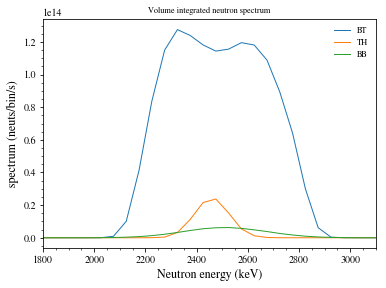

In [11]:
plt.figure()
plt.plot(En, bt_spec, label='BT')
plt.plot(En, th_spec, label='TH')
plt.plot(En, bb_spec, label='BB')
plt.xlabel('Neutron energy (keV)')
plt.ylabel('spectrum (neuts/bin/s)')
plt.title('Volume integrated neutron spectrum')
plt.legend()
plt.xlim(1800,3100)

We can also compute **spatially resolved spectra**, by setting the `integrate` keyword to `False`:

In [12]:
# Beam-target component (spatially resolved)
dist_a = fast_d_dist
dist_b = bulk_d_dist
bt_spec2 = dress.utils.calc_vols(vols, dist_a, dist_b, scalc, En_bins, 
                                integrate=False, quiet=False)

Now the calculated spectrum will be a 2D array, where the first dimension represents each of the given volume elements. The neutron emissivity from each volume element is obtained by simply summing (not integrating!) over the energy axis:

(1.8931929121597262, 3.911047702019433, -1.336941094652356, 1.8179012680944262)

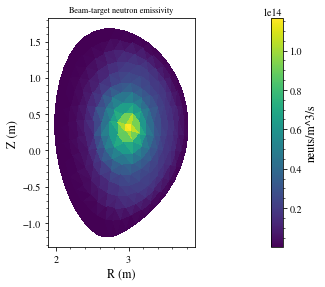

In [13]:
# Plot beam-target neutron emissivity profile
bt_ems = np.sum(bt_spec2, axis=1)
plt.tripcolor(vols.pos[0], vols.pos[1], bt_ems)
plt.xlabel('R (m)')
plt.ylabel('Z (m)')
plt.title('Beam-target neutron emissivity')
cb = plt.colorbar()
cb.set_label('neuts/m^3/s')
plt.axis('scaled')